# Simulate network equilibration separation-of-timescales

Author: Jacob Parres-Gold (jacobparresgold@gmail.com)

Last Revised: 20240514

This notebook will use deterministic simulations, via numerical integration of ordinary differential equations (ODEs), to simulate the dynamics of a dimerization network as an input monomer is continuously perturbed.

Here, I am going to assume that all coiled-coils have about the same $k_{on}$ rate of $5 \times 10^{5} M^{-1}s^{-1}$ as per [this reference](https://doi.org/10.1021/bi9530604), and that differences in affinity are thus due to differences in $k_{off}$. 

To convert from arbitrary K units to real molecule counts, I will consider 0.001 (unitless), which was our lower concentration limit in the large parameter screen, as 1 molecule. I will consider the volume of a mammalian cell as approximately 3 pL ($10^{-12} L$). 

In [2]:
import os
import sys
import pathlib

import itertools
import numpy as np
# import progressbar
import time
from tqdm.notebook import tqdm
import datetime

# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker
from matplotlib import rcParams
import seaborn as sns

# EQTK to calculate equilibrium concentrations - install instructions here https://eqtk.github.io/getting_started/eqtk_installation.html
import eqtk

# Ray for parallelization - install instructions here https://docs.ray.io/en/latest/ray-overview/installation.html
# import ray

# Networkx for graphs - install instructions here https://networkx.org/documentation/stable/install.html
import networkx as nx

In [3]:
# Load utility functions from dimer_network_utilities.py
utilities_path = str(pathlib.Path('C:\\Users','jacob','Local_Coding',\
                                  'ElowitzLab','Promiscuous_Networks','Notebooks','Paper_Notebooks')) # Directory of your utilities.py file
sys.path.append(utilities_path)
from dimer_network_utilities import *

In [3]:
# Initialize ray
# _ = ray.init(ignore_reinit_error=True)

# Initialize ray without warnings
import logging
_ = ray.init(ignore_reinit_error=True,configure_logging=True,logging_level=logging.ERROR,\
             log_to_driver=False) # Disable this to see error messages

In [542]:
# To shut down ray:
# ray.shutdown()

In [4]:
def restart_ray(warnings=True):
    ray.shutdown()
    if warnings:
        _ = ray.init(ignore_reinit_error=True)
    else:
        _ = ray.init(ignore_reinit_error=True,configure_logging=True,logging_level=logging.ERROR,\
             log_to_driver=False) # Disable this to see error messages
    return

In [5]:
# Define directory to save to
out_dir = str(pathlib.Path('/home/ubuntu','Data','20240506_timevarying_input'))

if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
    
# For plots
if not os.path.isdir(pathlib.Path(out_dir,'plots')):
    os.mkdir(pathlib.Path(out_dir,'plots'))

In [4]:
# Plotting settings
rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],	
    "font.size":9,
    "axes.titlesize":9,
    "axes.labelsize":9,
    "xtick.labelsize":9,
    "ytick.labelsize":9,
    "savefig.dpi": 900, 
    'figure.figsize': [6.0, 4.0],
    'figure.dpi': 150,
    'pdf.fonttype':42,
    'ps.fonttype':42,
})

In [7]:
# Print package versions
import pkg_resources
imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

print("Package versions:")
print("python={}".format(sys.version.split('|')[0].replace(' ','')))
for r in requirements:
    print("{}={}".format(*r))

Package versions:
python=3.8.13
eqtk=0.1.3
matplotlib=3.7.1
networkx=2.7.1
numpy=1.21.5
pandas=1.4.1
scipy=1.10.1


C:\Users\jacob\AppData\Local\Temp\ipykernel_31688\3780498324.py:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


## Define simulation function

In [8]:
def simulate_networks_custominput(m, num_inputs, param_sets, input_conditions):
    """
    Run simulations for dimer networks, over a matrix of concentrations for multiple monomers. 
    When >1 monomers are varied (e.g., a 2D matrix), the first monomer is sampled outermost, while the second
    is sampled inner to that.
    
    Parameters
    ----------
    m : int. 
        Number of monomer species. 
    num_inputs: int
        Number of monomers to count as inputs (those titrated). 
        E.g., if num_inputs=2, the first two monomers will be treated as inputs.
    param_sets : array_like shape (num_sets, num_parameters)
        Parameters sets for simulating dimerization networks.  
    input_conditions : array_like shape (num_input_conditions, num_inputs)
        Different input conditions to simulate for each parameter set
    
    Returns
    -------
    C0 : array_like shape (t, number of species)
        Initial concentration array used for eqtk.solve
    S_all : array_like 
        Equlibrium concentration of all species (monomers & dimers)
        for all parameter sets. 
        
    """
    #Create stoichiometry matrix and initial concnetration matrix 
    num_sets = param_sets.shape[0]
    num_dimers = number_of_dimers(m)
    N = make_nXn_stoich_matrix(m)
    num_rxns = N.shape[0]
    
    C0 = np.hstack((input_conditions, np.zeros((input_conditions.shape[0], (m-num_inputs)+num_dimers))))
    
    acc_monomer_ind = np.arange(num_inputs,m)
    S_all = np.zeros((C0.shape[0], C0.shape[1], num_sets))
    for pset_index, pset in enumerate(param_sets):
        S_all[:,:,pset_index] = run_eqtk(N, C0.copy(), pset, acc_monomer_ind)
    return C0,S_all  

## Large survey

We are going to screen many different networks, network sizes, etc. to see at which timescales the real results start to diverge from the equilibrium assumptions.

In [13]:
m_list = list(range(2,13)) # Network sizes to test

In [14]:
param_sets_per_m = 10

In [15]:
periods_to_test = np.logspace(2,5,7) # s

In [16]:
vol_per_cell = 1e-12 # L
unitless_conc_per_molecule = 0.001

k_on = 5e5 # M-1 s-1
k_on_unitless = k_on/6.0221e23/vol_per_cell # molecule-1 s-1

In [17]:
rng = np.random.default_rng()

In [18]:
def vary_input_logsine(t, log_baseline, log_amplitude, period):
    return 10**(log_baseline+(log_amplitude*np.sin(2*math.pi*t/period)))

def generate_timepoints_input_conditions(period,log_baseline=0,log_amplitude=3):
    time_len = period # s, total time to simulate
    timestep = 10 # Try not to make longer than 10 s
    num_timepoints = int(time_len//timestep)
    if num_timepoints<1000:
        num_timepoints = int(1000)
        timestep = time_len/num_timepoints
    timepoints = np.linspace(0, time_len, num_timepoints, endpoint=False)
    vary_input_logsine_vectorized = np.vectorize(vary_input_logsine,excluded=['log_baseline', 'log_amplitude', 'period'])
    input_conditions = np.expand_dims(vary_input_logsine_vectorized(timepoints,log_baseline=log_baseline, log_amplitude=log_amplitude, period=period),axis=1)
    
    return timepoints, input_conditions

In [ ]:
def return_diff_eq_right_sides(current_species_amounts, t, k_on_unitless, k_offs,m,dimers,unitless_conc_per_molecule,\
                               species_with_input,stoichiometry,timepoints,timestep,input_conditions, progressbar=None, progress=None):
    t_i = np.argmin(np.abs(timepoints - t)) # Estimate which timepoint we're on
    # Estimate how much total input needs to change
    desired_total_input = input_conditions[t_i,0]/unitless_conc_per_molecule
    actual_total_input = np.sum(current_species_amounts[species_with_input]*stoichiometry)
    # timestep = (timepoints[t_i+1]-timepoints[t_i]) if timepoints[t_i]<timepoints[-1] else (timepoints[t_i]-timepoints[t_i-1])
    d_input_dt = (desired_total_input-actual_total_input)/(timestep)
    derivatives = []
    for monomer in range(m):
        dimers_with_monomer = [dimer for dimer,monomers in enumerate(dimers) if monomer in monomers]
        stoichiometry=[2 if np.all(np.array(dimers[dimer_i])==monomer) else 1 for dimer_i in dimers_with_monomer]
        derivative = np.sum([(k_offs[dimer]*current_species_amounts[m+dimer]*stoichiometry[i])-\
                                   (k_on_unitless*current_species_amounts[dimers[dimer][0]]*current_species_amounts[dimers[dimer][1]]*stoichiometry[i])\
                                    for i,dimer in enumerate(dimers_with_monomer)])
        if monomer==0:
            fraction_free = current_species_amounts[monomer]/(current_species_amounts[monomer]+\
                                    np.sum([current_species_amounts[m+dimer] for dimer in dimers_with_monomer]))
            derivative+=(d_input_dt*fraction_free/unitless_conc_per_molecule)
        derivatives.append(derivative)
    for dimer,monomers in enumerate(dimers):
        derivative = (k_on_unitless*current_species_amounts[monomers[0]]*current_species_amounts[monomers[1]])-\
                           (k_offs[dimer]*current_species_amounts[m+dimer])
        if 0 in monomers:
            dimers_with_input = [dimer for dimer,monomers in enumerate(dimers) if 0 in monomers]
            fraction_thisdimer = current_species_amounts[m+dimer]/(current_species_amounts[0]+\
                                    np.sum([current_species_amounts[m+dimer2]*np.sum(dimers[dimer2]==0) for dimer2 in dimers_with_input]))
            derivative+=(d_input_dt*fraction_thisdimer*np.sum(monomers==0)/unitless_conc_per_molecule)
            # Also do the opposite for the other corresponding monomer
            if monomers[1]!=0:
                # MAKE SURE DIMERS IS SORTED
                derivatives[monomers[1]]-=(d_input_dt*fraction_thisdimer*np.sum(monomers==0)/unitless_conc_per_molecule)
        derivatives.append(derivative)
    # Update progress bar
    if progressbar:
        last_t, timestep = progress
        if t>=last_t+timestep:
            progressbar.update(1) # Increment to add
            progress[0] = last_t+timestep # Update last_t
    
    return derivatives

In [19]:
def check_mass_conservation(m,solved_kinetics,eq_concs,tolerance,tolerance_type='abs'):
    '''
    Function to check whether all dimers are at equilibrium following a numerical ODE integration.

    Inputs:
    -------
    solved_kinetics: np.array, shape (m+num_combos_with_replacement(m,2),len(timepoints))
        Array of concentrations of all species over time, as solved by scipy.integrate.odeint
    eq_concs: np.array, shape (m+num_combos_with_replacement(m,2),len(timepoints))
        Array of equilibrium concentrations of all species, as solved by simulate_networks_manual
    tolerance_type: str, 'abs' or 'rel' (default 'abs')
        If 'abs': tolerance is the maximum absolute difference between the known equilibrium value and the numerical solution
        If 'rel': tolerance is the maximum ratio between the known equilibrium value and the numerical solution. 
            For example, tolerance=0.1 if all species must be within 10% of the equilibrium value.
    
    Returns:
    --------
    bool: True if all species are within tolerance of the equilibrium value
    '''
    dimers = np.array(list(itertools.combinations_with_replacement(range(m),2)))
    eq_monomer_totals = []
    actual_monomer_totals = []
    for monomer in range(m):
        species_with_input = np.hstack(([monomer],[m+dimer for dimer,monomers in enumerate(dimers) if \
                                         len(set(monomers).intersection(set([monomer])))>0]))
        stoichiometry = np.hstack(([1],[np.sum(monomers==monomer) for dimer,monomers in enumerate(dimers) if \
                                         len(set(monomers).intersection(set([monomer])))>0]))
        actual_monomer_totals.append(np.sum(solved_kinetics[species_with_input,:]*np.expand_dims(stoichiometry,axis=1),axis=0))
        eq_monomer_totals.append(np.sum(eq_concs[:,species_with_input]*stoichiometry,axis=1))
    if tolerance_type=='abs':
        return np.all([np.all(np.abs(eq_monomer_totals[monomer]-actual_monomer_totals[monomer])<=tolerance) \
                       for monomer in range(m)])
    elif tolerance_type=='rel':
        max_allowed_ratio = 1+tolerance
        min_allowed_ratio = max(0,1-tolerance)
        return np.all([(np.all((np.abs(eq_monomer_totals[monomer]-actual_monomer_totals[monomer])/eq_monomer_totals[monomer])<=max_allowed_ratio) and\
                        np.all((np.abs(eq_monomer_totals[monomer]-actual_monomer_totals[monomer])/eq_monomer_totals[monomer])>=min_allowed_ratio))\
                       for monomer in range(m)])

In [20]:
def calculate_RMSD(points1,points2):
    if len(points1)!=len(points2):
        print("Two datasets must be of same length.")
        return np.nan
    square_differences = (points1-points2)**2
    return np.sqrt(np.sum(square_differences)/len(square_differences))

In [21]:
def calculate_chebyshev(points1,points2):
    if len(points1)!=len(points2):
        print("Two datasets must be of same length.")
        return np.nan
    return np.max(np.abs(points1-points2))

Generate parameter sets:

In [908]:
overwrite = False

for m in m_list:
    edge_key = {}
    homo_edges = []
    hetero_edges = []

    for i,combo in enumerate(itertools.combinations_with_replacement(range(m),r=2)):
        edge_key[(combo[0],combo[1])] = i
        if combo[0]==combo[1]:
            homo_edges.append(i)
        else:
            hetero_edges.append(i)
    
    # Sample networks with different connectivity evenly
    min_edges = m - 1
    max_edges = num_combos(m,2)
    num_possible_num_edges = max_edges - min_edges + 1
    possible_num_edges = list(range(min_edges,max_edges+1))
    num_edges_to_test = np.array(possible_num_edges)[np.array([round(x) for x in np.linspace(0,num_possible_num_edges-1,param_sets_per_m)])]

    null_K = 1e-10
    null_K_homo_fraction=0.25
    K_log_range = [-3,1]
    A_log_range = [-3,3]

    param_sets = np.concatenate((np.full((param_sets_per_m,num_combos_with_replacement(m,r=2)),null_K),np.ones((param_sets_per_m,m-1))),axis=1)
    where_edges_by_paramset = []
    for param_set_i, num_edges in enumerate(num_edges_to_test):
        param_set = param_sets[param_set_i]
        graph = nx.gnm_random_graph(n=m,m=num_edges)
        if num_edges<=math.comb(m-1,2):
            # If false, graph is always connected
            while not nx.is_connected(graph):
                graph = nx.gnm_random_graph(n=m,m=num_edges)
        edge_indices = list(sorted([edge_key[x] for x in graph.edges]))
        where_edges_by_paramset.append(np.array(edge_indices))
        # Fill heterodimer K's
        param_set[edge_indices] = 10**rng.uniform(K_log_range[0],K_log_range[1],size=(num_edges,))
        # Fill homodimer K's
        homo_edges_tofill = rng.choice(homo_edges,size=(round((1-null_K_homo_fraction)*m),),replace=False)
        param_set[homo_edges_tofill] = 10**rng.uniform(K_log_range[0],K_log_range[1],size=homo_edges_tofill.shape)
        # Fill A's
        param_set[-(m-1):] = 10**rng.uniform(A_log_range[0],A_log_range[1],size=(m-1,))
        
        param_sets[param_set_i] = param_set
    
    specific_out_dir = str(pathlib.Path(out_dir,f'{m}M'))
    if not os.path.isdir(specific_out_dir):
        os.mkdir(specific_out_dir)
    
    if (f'num_edges_to_test.npy' not in os.listdir(specific_out_dir)) or overwrite:
        np.save(str(pathlib.Path(specific_out_dir, f'num_edges_to_test.npy')),num_edges_to_test,allow_pickle=True)
    if (f'param_sets.npy' not in os.listdir(specific_out_dir)) or overwrite:
        np.save(str(pathlib.Path(specific_out_dir, f'param_sets.npy')),param_sets,allow_pickle=True)
    if (f'where_edges_by_paramset.npy' not in os.listdir(specific_out_dir)) or overwrite:
        np.save(str(pathlib.Path(specific_out_dir, f'where_edges_by_paramset.npy')),np.array(where_edges_by_paramset,dtype=object),allow_pickle=True)

Function to analyze each parameter set:

In [584]:
# @ray.remote
# def ray_analyze_timescales(m,param_set,param_set_i,periods_to_test):
    
#     time1 = time.time()
    
#     specific_out_dir = str(pathlib.Path(out_dir,f'{m}M'))
#     if not os.path.isdir(specific_out_dir):
#         os.mkdir(specific_out_dir)
    
#     rmsds_by_dimer_by_timescale = []
#     chebyshevdists_by_dimer_by_timescale = []
#     reports = []
    
#     dimers = np.array(list(itertools.combinations_with_replacement(range(m),2)))
    
#     for period_i, period in enumerate(periods_to_test):
#         report = f"m={m}\n"
#         report += f"Parameter set {param_set_i}\n"
#         report+= f"Testing period {period:.1e} s\n"
#         report+= f"\tTime since start: {str(datetime.timedelta(seconds=round(time.time()-time1,0)))}\n"
        
#         # Create timepoints and time-varying input conditions
#         timepoints, input_conditions = generate_timepoints_input_conditions(period,log_baseline=0,log_amplitude=3)
#         timestep = timepoints[1] - timepoints[0]
#         # Calculate equilibrium solutions
#         C0, eq_concs = simulate_networks_custominput(m, num_inputs=1, param_sets=np.expand_dims(param_set,axis=0), input_conditions=input_conditions)
#         eq_concs = eq_concs[:,:,0]/unitless_conc_per_molecule
        
#         # Convert parameters to more relevant units
#         K = param_set[:num_combos_with_replacement(m,2)] # Affinities
#         K_molec = K*unitless_conc_per_molecule # (molecule/cell)-1, affinities in molecule units
#         k_offs = k_on_unitless/K_molec # s-1, binding off rates, for each dimer

#         # Define initial concentrations
#         initial_equilibrium_species_concs = eq_concs[0,:] # already molecule/cell

#         report+="\tSolving ODE kinetics\n"
#         report+= f"\tTime since start: {str(datetime.timedelta(seconds=round(time.time()-time1,0)))}\n"
        
#         species_with_input = np.array([0]+[m+dimer for dimer,monomers in enumerate(dimers) if \
#                              len(set(monomers).intersection(set(range(num_inputs))))>0])
#         stoichiometry = np.array([1]+[np.sum(monomers==0) for dimer,monomers in enumerate(dimers) if \
#                                          len(set(monomers).intersection(set(range(num_inputs))))>0])
        
#         # progressbar = tqdm(total=len(timepoints),initial=1)
#         # progress = [timepoints[0], (timepoints[1]-timepoints[0])] # last_t, timestep
        
#         # Integrate ODEs without progress bar (progressbar=None)
#         solved_kinetics = scipy.integrate.odeint(func=return_diff_eq_right_sides, y0=initial_equilibrium_species_concs, t=timepoints,\
#                                         args = (k_on_unitless,k_offs,m,dimers,unitless_conc_per_molecule,\
#                                                 species_with_input, stoichiometry,timepoints,timestep,input_conditions,None,None)).T
#         success = check_mass_conservation(m=m,solved_kinetics=solved_kinetics,eq_concs=eq_concs,tolerance=1,tolerance_type='abs')
#         if not success:
#             report+=f'\t\t\tWARNING: m={m}, parameter set {param_set_i}, period {period:.1e} s FAILED\n'
        
#         report+="\tMeasuring RMSDs\n"
#         report+= f"\tTime since start: {str(datetime.timedelta(seconds=round(time.time()-time1,0)))}\n"
        
#         np.save(str(pathlib.Path(specific_out_dir,f'timepoints_paramset{param_set_i}_period{period_i}.npy')),timepoints)
#         np.save(str(pathlib.Path(specific_out_dir,f'eq_concs_paramset{param_set_i}_period{period_i}.npy')),eq_concs)
#         np.save(str(pathlib.Path(specific_out_dir,f'solved_kinetics_paramset{param_set_i}_period{period_i}.npy')),solved_kinetics)
        
#         # Round data < 1 molecule/cell
#         eq_concs[np.where(eq_concs<=1)] = 1
#         solved_kinetics[np.where(solved_kinetics<=1)] = 1
        
#         rmsds_by_dimer = []
#         chebyshevdists_by_dimer = []
#         for dimer in range(dimers.shape[0]):
#             rmsds_by_dimer.append(calculate_RMSD(np.log10(eq_concs[:,m+dimer]),np.log10(solved_kinetics[m+dimer,:])))
#             chebyshevdists_by_dimer.append(calculate_chebyshev(np.log10(eq_concs[:,m+dimer]),np.log10(solved_kinetics[m+dimer,:])))
#         rmsds_by_dimer_by_timescale.append(rmsds_by_dimer)
#         chebyshevdists_by_dimer_by_timescale.append(chebyshevdists_by_dimer)
#         reports.append(report)

#         del C0,solved_kinetics,eq_concs
    
#     np.save(str(pathlib.Path(specific_out_dir,f'rmsds_by_dimer_by_timescale_paramset{param_set_i}.npy')),rmsds_by_dimer_by_timescale)
#     np.save(str(pathlib.Path(specific_out_dir,f'chebyshevdists_by_dimer_by_timescale_paramset{param_set_i}.npy')),chebyshevdists_by_dimer_by_timescale)
#     np.save(str(pathlib.Path(specific_out_dir,f'reports_paramset{param_set_i}.npy')),reports)
    
#     print(f"Finished m={m} parameter set {param_set_i}")
    
#     return rmsds_by_dimer_by_timescale,chebyshevdists_by_dimer_by_timescale

In [25]:
@ray.remote
def ray_analyze_timescales(m,param_set,param_set_i,period,period_i):
    
    time1 = time.time()
    
    specific_out_dir = str(pathlib.Path(out_dir,f'{m}M'))
    if not os.path.isdir(specific_out_dir):
        os.mkdir(specific_out_dir)
    
    reports = []
    
    dimers = np.array(list(itertools.combinations_with_replacement(range(m),2)))
    
    report = f"m={m}\n"
    report += f"Parameter set {param_set_i}\n"
    report+= f"Testing period {period:.1e} s\n"
    report+= f"\tTime since start: {str(datetime.timedelta(seconds=round(time.time()-time1,0)))}\n"

    # Create timepoints and time-varying input conditions
    timepoints, input_conditions = generate_timepoints_input_conditions(period,log_baseline=0,log_amplitude=3)
    timestep = timepoints[1] - timepoints[0]
    # Calculate equilibrium solutions
    C0, eq_concs = simulate_networks_custominput(m, num_inputs=1, param_sets=np.expand_dims(param_set,axis=0), input_conditions=input_conditions)
    eq_concs = eq_concs[:,:,0]/unitless_conc_per_molecule

    # Convert parameters to more relevant units
    K = param_set[:num_combos_with_replacement(m,2)] # Affinities
    K_molec = K*unitless_conc_per_molecule # (molecule/cell)-1, affinities in molecule units
    k_offs = k_on_unitless/K_molec # s-1, binding off rates, for each dimer

    # Define initial concentrations
    initial_equilibrium_species_concs = eq_concs[0,:] # already molecule/cell

    report+="\tSolving ODE kinetics\n"
    report+= f"\tTime since start: {str(datetime.timedelta(seconds=round(time.time()-time1,0)))}\n"

    species_with_input = np.array([0]+[m+dimer for dimer,monomers in enumerate(dimers) if \
                         len(set(monomers).intersection(set(range(num_inputs))))>0])
    stoichiometry = np.array([1]+[np.sum(monomers==0) for dimer,monomers in enumerate(dimers) if \
                                     len(set(monomers).intersection(set(range(num_inputs))))>0])

    # progressbar = tqdm(total=len(timepoints),initial=1)
    # progress = [timepoints[0], (timepoints[1]-timepoints[0])] # last_t, timestep

    # Integrate ODEs without progress bar (progressbar=None)
    solved_kinetics = scipy.integrate.odeint(func=return_diff_eq_right_sides, y0=initial_equilibrium_species_concs, t=timepoints,\
                                    args = (k_on_unitless,k_offs,m,dimers,unitless_conc_per_molecule,\
                                            species_with_input, stoichiometry,timepoints,timestep,input_conditions,None,None)).T
    success = check_mass_conservation(m=m,solved_kinetics=solved_kinetics,eq_concs=eq_concs,tolerance=1,tolerance_type='abs')
    if not success:
        report+=f'\t\t\tWARNING: m={m}, parameter set {param_set_i}, period {period:.1e} s FAILED\n'
        
    np.save(str(pathlib.Path(specific_out_dir,f'timepoints_paramset{param_set_i}_period{period_i}.npy')),timepoints)
    np.save(str(pathlib.Path(specific_out_dir,f'eq_concs_paramset{param_set_i}_period{period_i}.npy')),eq_concs)
    np.save(str(pathlib.Path(specific_out_dir,f'solved_kinetics_paramset{param_set_i}_period{period_i}.npy')),solved_kinetics)
    
    del C0,solved_kinetics,eq_concs
    
    print(f"Finished m={m}, parameter set {param_set_i}, period {period_i}")
    
    return

In [26]:
@ray.remote
def ray_analyze_deviations(m,param_set,param_set_i,periods_to_test):
    
    time1 = time.time()
    
    specific_out_dir = str(pathlib.Path(out_dir,f'{m}M'))
    if not os.path.isdir(specific_out_dir):
        os.mkdir(specific_out_dir)
    
    rmsds_by_dimer_by_timescale = []
    chebyshevdists_by_dimer_by_timescale = []
    reports = []
    
    dimers = np.array(list(itertools.combinations_with_replacement(range(m),2)))
    
    for period_i, period in enumerate(periods_to_test):
        report = f"m={m}\n"
        report += f"Parameter set {param_set_i}\n"
        report+= f"Testing period {period:.1e} s\n"
        report+= f"\tTime since start: {str(datetime.timedelta(seconds=round(time.time()-time1,0)))}\n"
        
        # Load data
        timepoints = np.load(str(pathlib.Path(specific_out_dir,f'timepoints_paramset{param_set_i}_period{period_i}.npy')),allow_pickle=True)
        eq_concs = np.load(str(pathlib.Path(specific_out_dir,f'eq_concs_paramset{param_set_i}_period{period_i}.npy')),allow_pickle=True)
        solved_kinetics = np.load(str(pathlib.Path(specific_out_dir,f'solved_kinetics_paramset{param_set_i}_period{period_i}.npy')),allow_pickle=True)
        
        report+="\tMeasuring RMSDs\n"
        report+= f"\tTime since start: {str(datetime.timedelta(seconds=round(time.time()-time1,0)))}\n"
        
        # Round data < 1 molecule/cell
        eq_concs[np.where(eq_concs<=1)] = 1
        solved_kinetics[np.where(solved_kinetics<=1)] = 1
        
        rmsds_by_dimer = []
        chebyshevdists_by_dimer = []
        for dimer in range(dimers.shape[0]):
            rmsds_by_dimer.append(calculate_RMSD(np.log10(eq_concs[:,m+dimer]),np.log10(solved_kinetics[m+dimer,:])))
            chebyshevdists_by_dimer.append(calculate_chebyshev(np.log10(eq_concs[:,m+dimer]),np.log10(solved_kinetics[m+dimer,:])))
        rmsds_by_dimer_by_timescale.append(rmsds_by_dimer)
        chebyshevdists_by_dimer_by_timescale.append(chebyshevdists_by_dimer)
        reports.append(report)

        del solved_kinetics,eq_concs
    
    np.save(str(pathlib.Path(specific_out_dir,f'rmsds_by_dimer_by_timescale_paramset{param_set_i}.npy')),rmsds_by_dimer_by_timescale)
    np.save(str(pathlib.Path(specific_out_dir,f'chebyshevdists_by_dimer_by_timescale_paramset{param_set_i}.npy')),chebyshevdists_by_dimer_by_timescale)
    np.save(str(pathlib.Path(specific_out_dir,f'reports_paramset{param_set_i}.npy')),reports)
    
    print(f"Finished m={m} parameter set {param_set_i}")
    
    return rmsds_by_dimer_by_timescale,chebyshevdists_by_dimer_by_timescale

In [ ]:
# np.save(str(pathlib.Path(out_dir,f'periods_to_test.npy')),periods_to_test)

# periods_to_test = np.load(str(pathlib.Path(out_dir,f'periods_to_test.npy')),allow_pickle=True)

Run simulations:

In [594]:
len(periods_to_test)

7

In [587]:
# m_list_temp = list(range(2,11)) # Network sizes to test
# periods_to_test_temp = periods_to_test

m_list_temp = list(range(11,13)) # Network sizes to test
periods_to_test_temp = periods_to_test[5:]

In [ ]:
futures_by_m_by_paramset = []
for m in m_list_temp:
    specific_out_dir = str(pathlib.Path(out_dir,f'{m}M'))
    param_sets = np.load(str(pathlib.Path(specific_out_dir, f'param_sets.npy')),allow_pickle=True)
    futures_thism = []
    for param_set_i, param_set in enumerate(param_sets):
        for period_i, period in enumerate(periods_to_test_temp):
            futures_thism.append(ray_analyze_timescales.remote(m=m,param_set=param_set,param_set_i=param_set_i,period=period,period_i=period_i))
    futures_by_m_by_paramset.append(futures_thism)

results_by_m_by_paramset = []
for m in m_list_temp:
    m_i = m_list_temp.index(m)
    results_thism = []
    for future in futures_by_m_by_paramset[m_i]:
        results_thism.append(ray.get(future))
    results_by_m_by_paramset.append(results_thism)

Measure differences:

In [23]:
# m_list_temp = list(range(2,11)) # Network sizes to test
# periods_to_test_temp = periods_to_test

m_list_temp = list(range(11,13)) # Network sizes to test
periods_to_test_temp = periods_to_test

In [27]:
futures_by_m_by_paramset = []
for m in m_list_temp:
    specific_out_dir = str(pathlib.Path(out_dir,f'{m}M'))
    param_sets = np.load(str(pathlib.Path(specific_out_dir, f'param_sets.npy')),allow_pickle=True)
    futures_thism = []
    for param_set_i, param_set in enumerate(param_sets):
        futures_thism.append(ray_analyze_deviations.remote(m=m,param_set=param_set,param_set_i=param_set_i,periods_to_test=periods_to_test_temp))
    futures_by_m_by_paramset.append(futures_thism)

results_by_m_by_paramset = []
for m in m_list_temp:
    m_i = m_list_temp.index(m)
    results_thism = []
    for future in futures_by_m_by_paramset[m_i]:
        results_thism.append(ray.get(future))
    results_by_m_by_paramset.append(results_thism)

In [538]:
restart_ray(warnings=False)

## Check for errors

In [28]:
m_list_temp = list(range(2,13)) # Network sizes to test

In [29]:
failed_ms = []
failed_paramsets = []
failed_periods = []

for m in m_list_temp:
    m_i = m_list.index(m)
    specific_out_dir = str(pathlib.Path(out_dir,f'{m}M'))
    param_sets = np.load(str(pathlib.Path(specific_out_dir, f'param_sets.npy')),allow_pickle=True)
    for param_set_i, param_set in enumerate(param_sets):
        reports = np.load(str(pathlib.Path(specific_out_dir,f'reports_paramset{param_set_i}.npy')),allow_pickle=True)
        is_warning = np.array(['WARNING' in report for report in reports])
        if np.any(is_warning):
            report = reports[np.where(is_warning)[0][0]]
            # print(report)
            sub_reports = report.split('\n')
            failed_ms.append(sub_reports[0][2:])
            failed_paramsets.append(sub_reports[1][14:])
            warning = [sub_report for sub_report in sub_reports if 'WARNING' in sub_report][0]
            failed_period = warning[warning.index('period')+7:warning.index('s FAILED')]
            failed_period_i = np.argmin(np.abs(periods_to_test-float(failed_period)))
            failed_periods.append(failed_period_i)

In [30]:
failed_df = pd.DataFrame(np.array([failed_ms,failed_paramsets,failed_periods]).T,columns=['m','param_set_i','period_i'])

failed_df.to_csv(str(pathlib.Path(out_dir,'failed_simulations.csv')),index=False)

display(failed_df)

,m,param_set_i,period_i
0,2,2,0
1,2,7,0
2,3,4,0
3,4,0,0
4,4,1,2
5,4,5,0
6,4,9,0
7,5,0,0
8,5,4,0
9,5,5,6


Make sure we still have enough good data for each condition:

In [36]:
for m in m_list_temp:
    print(f"m={m}")
    for period_i in range(len(periods_to_test)):
        percent_failed = 100*failed_df[(failed_df['m']==str(m))&(failed_df['period_i']==str(period_i))].shape[0]/(param_sets_per_m)
        if percent_failed>0:
            print("\tperiod_i={}: {:.1f}% failed".format(period_i,percent_failed))

m=2
	period_i=0: 20.0% failed
m=3
	period_i=0: 10.0% failed
m=4
	period_i=0: 30.0% failed
	period_i=2: 10.0% failed
m=5
	period_i=0: 30.0% failed
	period_i=6: 10.0% failed
m=6
	period_i=0: 30.0% failed
	period_i=5: 20.0% failed
m=7
	period_i=0: 30.0% failed
	period_i=1: 10.0% failed
m=8
	period_i=0: 40.0% failed
	period_i=1: 10.0% failed
m=9
	period_i=0: 30.0% failed
m=10
	period_i=0: 70.0% failed
m=11
m=12


## Plot overall

In [37]:
m_list_temp = list(range(2,13)) # Network sizes to test

In [38]:
metric = 'rmsd' # 'rmsd' or 'chebyshev'

In [39]:
chebyshev_threshold = 0.5

/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 28.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 6.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 30.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


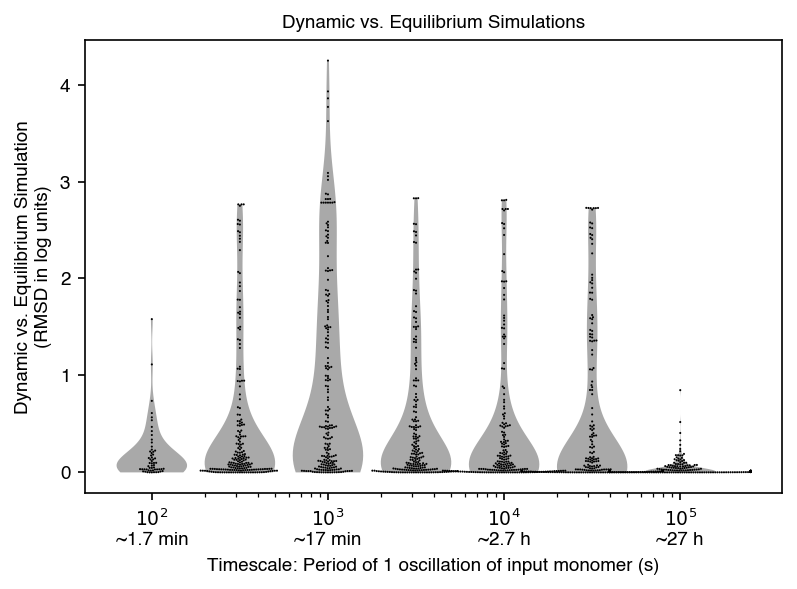

In [40]:
fig, ax = plt.subplots()

periods_to_test = np.load(str(pathlib.Path(out_dir, f'periods_to_test.npy')),allow_pickle=True)
failed_df = pd.read_csv(str(pathlib.Path(out_dir,'failed_simulations.csv')))

data_by_timescale = [[] for period_i in range(len(periods_to_test))] 

# for m in m_list_temp:
m = 10
m_i = m_list.index(m)
specific_out_dir = str(pathlib.Path(out_dir,f'{m}M'))
param_sets = np.load(str(pathlib.Path(specific_out_dir, f'param_sets.npy')),allow_pickle=True)
where_edges_by_paramset = np.load(str(pathlib.Path(specific_out_dir, f'where_edges_by_paramset.npy')),allow_pickle=True)
for param_set_i, param_set in enumerate(param_sets):
    if metric == 'rmsd':
        data_by_dimer_by_timescale = np.load(str(pathlib.Path(specific_out_dir,f'rmsds_by_dimer_by_timescale_paramset{param_set_i}.npy')),allow_pickle=True)
    elif metric == 'chebyshev':
        data_by_dimer_by_timescale = np.load(str(pathlib.Path(specific_out_dir,f'chebyshevdists_by_dimer_by_timescale_paramset{param_set_i}.npy')),allow_pickle=True)
    for period_i, period in enumerate(periods_to_test):
        # Skip if this simulation failed
        if (failed_df == [m,param_set_i,period_i]).all(axis=1).any():
            continue
        # Exclude data from non-existent dimers
        # data_temp = data_by_dimer_by_timescale[period_i][where_edges_by_paramset[param_set_i]]
        # Exclude data from dimers with zero abundance
        eq_concs = np.load(str(pathlib.Path(specific_out_dir,f'eq_concs_paramset{param_set_i}_period{period_i}.npy')),allow_pickle=True)
        where_dimers_nonzero = np.any(eq_concs[:,m:]>1,axis=0)
        data_temp = data_by_dimer_by_timescale[period_i][where_dimers_nonzero]
        # Add to overall list
        data_by_timescale[period_i] += list(data_temp)

x_positions = np.log10(periods_to_test)
dataset = data_by_timescale.copy()
widths=0.4
s = 1
color='darkgray'
alpha=1
plotpoints = True
subsample = False
xname = 'Timescale: Period of 1 oscillation of input monomer (s)'
if metric == 'rmsd':
    yname = 'Dynamic vs. Equilibrium Simulation\n(RMSD in log units)'
elif metric == 'chebyshev':
    yname = 'Dynamic vs. Equilibrium Simulation\n(Worst-point difference in log units)'

# Violin plot with points 
parts = ax.violinplot(positions = x_positions,\
           dataset = dataset,\
           widths=widths,\
          #  labels = [str(m) for m in m_list_temp],\
          showmedians=False,\
          showextrema=False,\
          showmeans=False,\
)
for face in parts['bodies']:
    face.set_facecolor(color)
    face.set_alpha(1)
# parts['cmedians'].set_color('r')
# parts['cmedians'].set_linewidth(1)

if plotpoints:
    if type(subsample)==int:
        rng = np.random.default_rng()
    for x_pos_i, x_pos in enumerate(x_positions):
        points = dataset[x_pos_i]
        # ax.plot([m+rng.normal(0,0.1) for x in points],points,marker=marker,linestyle='',color='k',markersize=s,\
        #         markeredgewidth=0,alpha=alpha)
        if type(subsample)==int and len(points)>subsample:
            points = rng.choice(points,size=subsample,replace=False)
        subsample_df = pd.DataFrame({xname:np.full((len(points),),x_pos),yname:points})
        sns.swarmplot(data=subsample_df,x=xname,y=yname,orient='v',native_scale=True,\
            color='k',size=s,alpha=alpha,edgecolor='none',ax=ax)

# parts['cmedians'].set_zorder(10)

# Set x ticks
x_tick_approximations = [
    '~1.7 min',
    '~17 min',
    '~2.7 h',
    '~27 h'
]

xmin = math.floor(x_positions[0])
xmax = math.ceil(x_positions[-1])
log_xtick_locations_inclusive = np.arange(xmin,xmax+1)
log_xtick_locations = np.arange(xmin,xmax)
_ = ax.set_xticks(log_xtick_locations_inclusive)
label_every = 1
_ = ax.set_xticklabels(['$10^{{{}}}$\n{}'.format(x,x_tick_approximations[i]) if i%label_every==0 else '' for i,x in enumerate(log_xtick_locations_inclusive)])
_ = ax.set_xticks(list(itertools.chain.from_iterable([[np.log10((10**float(x))*y) for y in np.arange(2,10)] \
            for x in log_xtick_locations])),minor=True)

# Add horizontal threshold
if metric == 'chebyshev':
    test = ax.axhline(y=chebyshev_threshold,ls='--',linewidth=1,color='r',marker='')

# Set title
_ = ax.set_title('Dynamic vs. Equilibrium Simulations')

In [ ]:
periods_to_test = np.load(str(pathlib.Path(out_dir, f'periods_to_test.npy')),allow_pickle=True)
failed_df = pd.read_csv(str(pathlib.Path(out_dir,'failed_simulations.csv')))

max_log_range_constant_dimer = 0.5

fraction_acceptable_by_timescale_by_m = []
fraction_simulations_failed_by_timescale_by_m = []
stdev_fraction_acceptable_by_timescale_by_m = []
min_fraction_acceptable_by_timescale_by_m = []
max_fraction_acceptable_by_timescale_by_m = []
Q1_fraction_acceptable_by_timescale_by_m = []
Q3_fraction_acceptable_by_timescale_by_m = []

for m in m_list:
    m_i = m_list.index(m)
    specific_out_dir = str(pathlib.Path(out_dir,f'{m}M'))
    param_sets = np.load(str(pathlib.Path(specific_out_dir, f'param_sets.npy')),allow_pickle=True)
    all_data_by_timescale = [[] for period_i in range(len(periods_to_test))] 
    fraction_acceptable_by_network_by_timescale = [[] for period_i in range(len(periods_to_test))] 
    failed_count_by_timescale = [0 for period_i in range(len(periods_to_test))]
    for param_set_i, param_set in enumerate(param_sets):
        # Use chebyshev distance
        data_by_dimer_by_timescale = np.load(str(pathlib.Path(specific_out_dir,f'chebyshevdists_by_dimer_by_timescale_paramset{param_set_i}.npy')),allow_pickle=True)
        for period_i, period in enumerate(periods_to_test):
            # Skip if this simulation failed
            if (failed_df == [m,param_set_i,period_i]).all(axis=1).any():
                failed_count_by_timescale[period_i] += 1
                continue
            # Exclude data from dimers with zero abundance
            eq_concs = np.load(str(pathlib.Path(specific_out_dir,f'eq_concs_paramset{param_set_i}_period{period_i}.npy')),allow_pickle=True)
            where_dimers_nonzero = np.any(eq_concs[:,m:]>1,axis=0)
            # Exclude data from dimers with constant abundance
            where_dimers_nonconst = (np.max(np.log10(eq_concs[:,m:]),axis=0)-np.min(np.log10(eq_concs[:,m:]),axis=0))>max_log_range_constant_dimer
            data_temp = data_by_dimer_by_timescale[period_i][(where_dimers_nonzero)&(where_dimers_nonconst)]
            # Add to overall list
            all_data_by_timescale[period_i] += list(data_temp)
            # Fraction acceptable
            fraction_acceptable_by_network_by_timescale[period_i].append(np.where(data_temp<=chebyshev_threshold)[0].shape[0]/data_temp.shape[0])
    
    all_data_by_timescale = [np.array(x) for x in all_data_by_timescale]   
    fraction_simulations_failed_by_timescale_by_m.append(np.array(failed_count_by_timescale)/param_sets.shape[0])

    x_positions = np.log10(periods_to_test)

    # Fraction acceptable
    fraction_acceptable = [np.where(all_data_by_timescale[period_i]<=chebyshev_threshold)[0].shape[0]/all_data_by_timescale[period_i].shape[0] for period_i in range(len(periods_to_test))]
    fraction_acceptable_by_timescale_by_m.append(fraction_acceptable)

    stdev_fraction = [np.std(fraction_acceptable_by_network_by_timescale[period_i]) for period_i in range(len(periods_to_test))]
    min_fraction = [np.max(fraction_acceptable_by_network_by_timescale[period_i]) for period_i in range(len(periods_to_test))]
    max_fraction = [np.min(fraction_acceptable_by_network_by_timescale[period_i]) for period_i in range(len(periods_to_test))]
    Q1_fraction = [np.quantile(fraction_acceptable_by_network_by_timescale[period_i],0.25) for period_i in range(len(periods_to_test))]
    Q3_fraction = [np.quantile(fraction_acceptable_by_network_by_timescale[period_i],0.75) for period_i in range(len(periods_to_test))]

    stdev_fraction_acceptable_by_timescale_by_m.append(stdev_fraction)
    min_fraction_acceptable_by_timescale_by_m.append(min_fraction)
    max_fraction_acceptable_by_timescale_by_m.append(max_fraction)
    Q1_fraction_acceptable_by_timescale_by_m.append(Q1_fraction)
    Q3_fraction_acceptable_by_timescale_by_m.append(Q3_fraction)

In [ ]:
np.save(str(pathlib.Path(out_dir,'fraction_acceptable_by_timescale_by_m.npy')), fraction_acceptable_by_timescale_by_m, allow_pickle=True)
np.save(str(pathlib.Path(out_dir,'stdev_fraction_acceptable_by_timescale_by_m.npy')), stdev_fraction_acceptable_by_timescale_by_m, allow_pickle=True)
np.save(str(pathlib.Path(out_dir,'min_fraction_acceptable_by_timescale_by_m.npy')), min_fraction_acceptable_by_timescale_by_m, allow_pickle=True)
np.save(str(pathlib.Path(out_dir,'max_fraction_acceptable_by_timescale_by_m.npy')), max_fraction_acceptable_by_timescale_by_m, allow_pickle=True)
np.save(str(pathlib.Path(out_dir,'Q1_fraction_acceptable_by_timescale_by_m.npy')), min_fraction_acceptable_by_timescale_by_m, allow_pickle=True)
np.save(str(pathlib.Path(out_dir,'Q3_fraction_acceptable_by_timescale_by_m.npy')), max_fraction_acceptable_by_timescale_by_m, allow_pickle=True)
np.save(str(pathlib.Path(out_dir,'fraction_simulations_failed_by_timescale_by_m.npy')), fraction_simulations_failed_by_timescale_by_m, allow_pickle=True)

In [ ]:
fraction_acceptable_by_timescale_by_m = np.load(str(pathlib.Path(out_dir,'fraction_acceptable_by_timescale_by_m.npy')), allow_pickle=True)
stdev_fraction_acceptable_by_timescale_by_m = np.load(str(pathlib.Path(out_dir,'stdev_fraction_acceptable_by_timescale_by_m.npy')), allow_pickle=True)
min_fraction_acceptable_by_timescale_by_m = np.load(str(pathlib.Path(out_dir,'min_fraction_acceptable_by_timescale_by_m.npy')), allow_pickle=True)
max_fraction_acceptable_by_timescale_by_m = np.load(str(pathlib.Path(out_dir,'max_fraction_acceptable_by_timescale_by_m.npy')), allow_pickle=True)
Q1_fraction_acceptable_by_timescale_by_m = np.load(str(pathlib.Path(out_dir,'Q1_fraction_acceptable_by_timescale_by_m.npy')), allow_pickle=True)
Q3_fraction_acceptable_by_timescale_by_m = np.load(str(pathlib.Path(out_dir,'Q3_fraction_acceptable_by_timescale_by_m.npy')), allow_pickle=True)
fraction_simulations_failed_by_timescale_by_m = np.load(str(pathlib.Path(out_dir,'fraction_simulations_failed_by_timescale_by_m.npy')), allow_pickle=True)

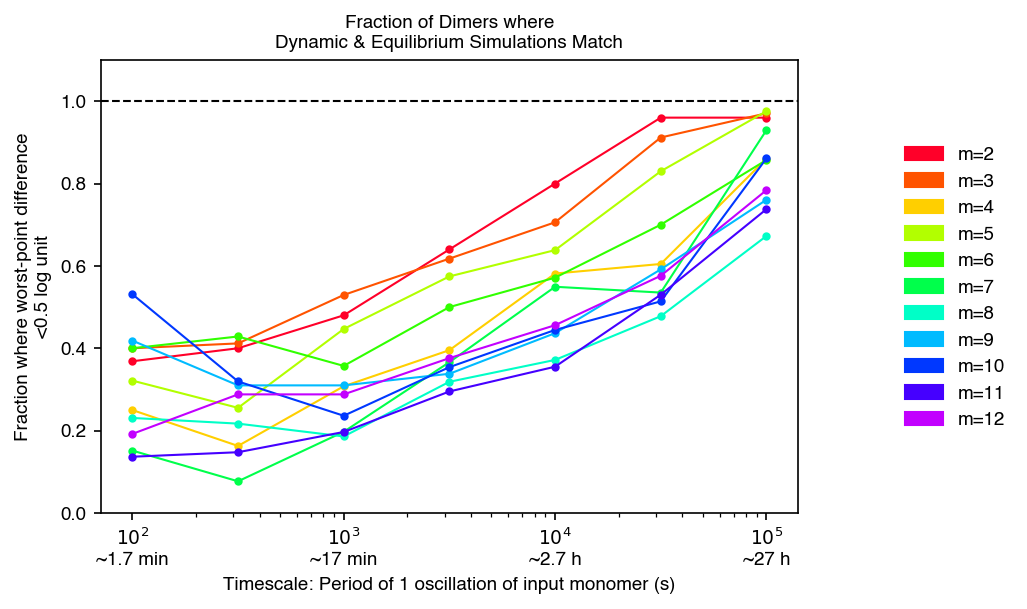

In [ ]:
save = True

fig, ax = plt.subplots()

cmap = plt.get_cmap('gist_rainbow')

x_positions = np.log10(periods_to_test)

for m in m_list_temp:
    m_i = m_list.index(m)
    _ = ax.plot(x_positions,fraction_acceptable_by_timescale_by_m[m_i],marker='.',markersize=6,linestyle='-',linewidth=1,color=cmap((m_i/(len(m_list)))))

# Set x ticks
x_tick_approximations = [
    '~1.7 min',
    '~17 min',
    '~2.7 h',
    '~27 h'
]

xmin = math.floor(x_positions[0])
xmax = math.ceil(x_positions[-1])
log_xtick_locations_inclusive = np.arange(xmin,xmax+1)
log_xtick_locations = np.arange(xmin,xmax)
_ = ax.set_xticks(log_xtick_locations_inclusive)
label_every = 1
_ = ax.set_xticklabels(['$10^{{{}}}$\n{}'.format(x,x_tick_approximations[i]) if i%label_every==0 else '' for i,x in enumerate(log_xtick_locations_inclusive)])
_ = ax.set_xticks(list(itertools.chain.from_iterable([[np.log10((10**float(x))*y) for y in np.arange(2,10)] \
            for x in log_xtick_locations])),minor=True)

_ = ax.set_xlabel('Timescale: Period of 1 oscillation of input monomer (s)')

# Set ylim
_ = ax.set_ylim([0,1.1])

_ =ax.set_ylabel(f'Fraction where worst-point difference\n<{chebyshev_threshold} log unit')

_ = ax.axhline(y=1, color='k', linestyle='--', linewidth=1)

# Set title
_ = ax.set_title('Fraction of Dimers where\nDynamic & Equilibrium Simulations Match')

# Legend
patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='none',\
    handles=list(patches.values()),\
    edgecolor='none')

if save:
    filename = f'fraction_acceptable_by_period_by_m'
    plt.savefig(str(pathlib.Path(out_dir,'plots',filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,'plots',filename+'.png')),dpi=900,bbox_inches='tight')

## Plot specific cases

In [515]:
m = 7
param_set_i = 4
period_i = 5

m_i = m_list.index(m)
specific_out_dir = str(pathlib.Path(out_dir,f'{m}M'))
param_sets = np.load(str(pathlib.Path(specific_out_dir, f'param_sets.npy')),allow_pickle=True)

timepoints = np.load(str(pathlib.Path(specific_out_dir,f'timepoints_paramset{param_set_i}_period{period_i}.npy')),allow_pickle=True)
eq_concs = np.load(str(pathlib.Path(specific_out_dir,f'eq_concs_paramset{param_set_i}_period{period_i}.npy')),allow_pickle=True)
solved_kinetics = np.load(str(pathlib.Path(specific_out_dir,f'solved_kinetics_paramset{param_set_i}_period{period_i}.npy')),allow_pickle=True)

period = periods_to_test[period_i]

dimers = np.array(list(itertools.combinations_with_replacement(range(m),2)))

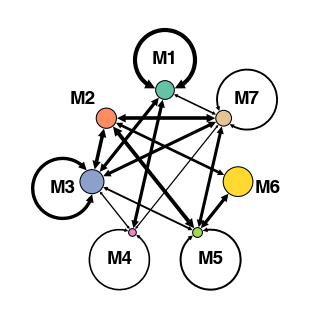

In [516]:
fig, axs = make_network_plots_polygon(m=m, n_input=1,param_sets=np.expand_dims(param_sets[param_set_i],axis=0), \
                                        univs_to_plot=np.array([0]),\
                                        ncols = 1,r_node = 0.5, r_loop = 0.2,\
                                        node_scales = [-3,3,4,15], input_node_values=np.array([0 for x in range(1)]),\
                                        K_edge_scales = [-3,1,0.5,2],input_cmap='Set2',\
                                        fontname = 'Helvetica',fontsize=9,non_output_dimer_color='k')

fig.set_dpi(150)

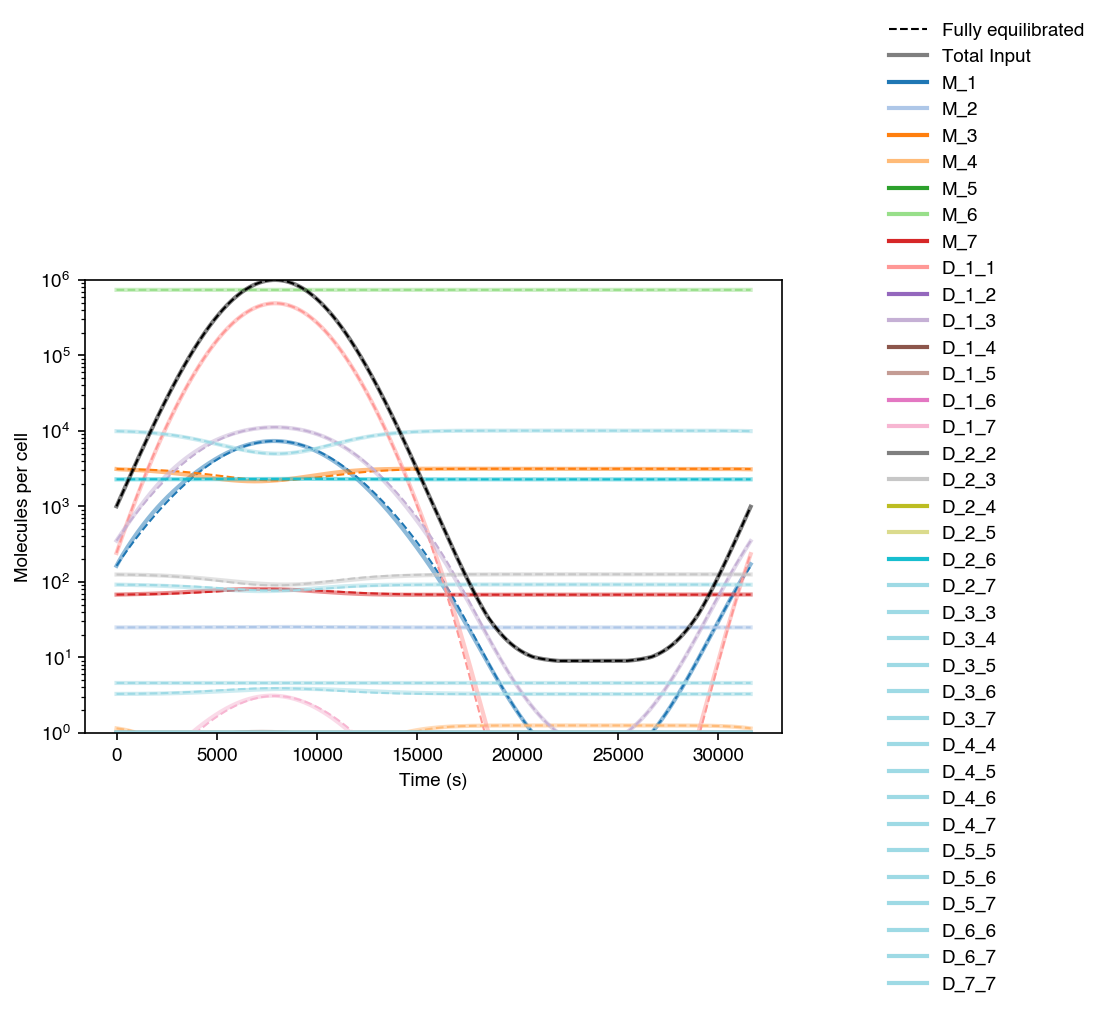

In [517]:
fig, ax = plt.subplots()

points_to_plot = 1000 # Number of points to sample and plot (plotting every point is slow)
plot_every = timepoints.shape[0]//points_to_plot

cmap = plt.get_cmap('tab20')

custom_cmap = mcolors.ListedColormap([cmap(i) for i in range(number_of_species(m))])

for species_to_plot in range(number_of_species(m)):
    _ = ax.plot(timepoints,solved_kinetics[species_to_plot,:],\
                marker='',lw=2,linestyle='-',color=custom_cmap(species_to_plot),alpha=0.5)
    _ = ax.plot(timepoints,eq_concs[:,species_to_plot],\
                marker='',lw=1,linestyle='--',color=custom_cmap(species_to_plot))

# Plot total input
input_monomer = 0
species_with_input = np.hstack(([input_monomer],\
                                [m+dimer for dimer,monomers in enumerate(dimers) if \
                                 len(set(monomers).intersection(set([input_monomer])))>0]))

stoichiometry = np.hstack(([1],[np.sum(monomers==input_monomer) for dimer,monomers in enumerate(dimers) if \
                                 len(set(monomers).intersection(set([input_monomer])))>0]))
    
_ = ax.plot(timepoints,np.sum(solved_kinetics[species_with_input,:]*np.expand_dims(stoichiometry,axis=1),axis=0),\
                marker='',lw=2,linestyle='-',color='k',alpha=0.5)
_ = ax.plot(timepoints,np.sum(eq_concs[:,species_with_input]*stoichiometry,axis=1),\
                marker='',lw=1,linestyle='--',color='k')


_ = ax.set_xlabel('Time (s)')
_ = ax.set_ylabel(f'Molecules per cell')
# _ = ax.set_title(f'{make_nXn_species_names(m)[species_to_plot]}')

_ = ax.set_yscale('log')
_ = ax.set_ylim([1e0,1e6])
# _ = ax.set_xlim([0,26])

# Create Legend
patches = {}
# patches['input'] = mlines.Line2D([],[],linestyle=':',linewidth=1,color='k', label='Total Input (ideal)')
patches['equilibrated'] = mlines.Line2D([],[],linestyle='--',linewidth=1,color='k', alpha=1,label='Fully equilibrated')
patches['input2'] = mlines.Line2D([],[],linestyle='-',linewidth=2,color='k', alpha=0.5,label='Total Input')

for species_to_plot in range(number_of_species(m)):
    patches[str(species_to_plot)] = mlines.Line2D([],[],linestyle='-',linewidth=2,color=custom_cmap(species_to_plot), label=make_nXn_species_names(m)[species_to_plot])

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='none',\
    handles=list(patches.values()),\
    edgecolor='none')

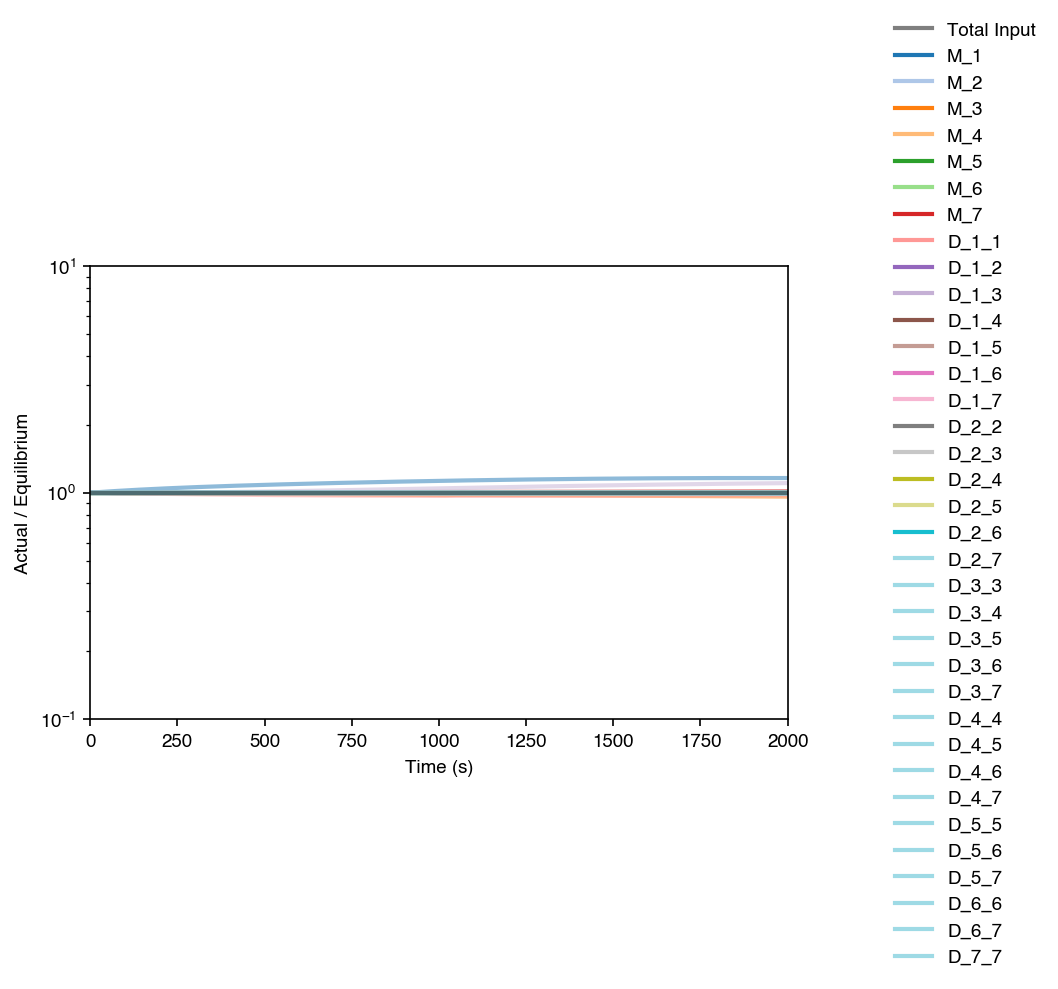

In [518]:
fig, ax = plt.subplots()

points_to_plot = 1000 # Number of points to sample and plot (plotting every point is slow)
plot_every = timepoints.shape[0]//points_to_plot

cmap = plt.get_cmap('tab20')

custom_cmap = mcolors.ListedColormap([cmap(i) for i in range(number_of_species(m))])

for species_to_plot in range(number_of_species(m)):
    _ = ax.plot(timepoints,solved_kinetics[species_to_plot,:]/eq_concs[:,species_to_plot],\
                marker='',lw=2,linestyle='-',color=custom_cmap(species_to_plot),alpha=0.5)

# Plot total input
input_monomer = 0
species_with_input = np.hstack(([input_monomer],\
                                [m+dimer for dimer,monomers in enumerate(dimers) if \
                                 len(set(monomers).intersection(set([input_monomer])))>0]))

stoichiometry = np.hstack(([1],[np.sum(monomers==input_monomer) for dimer,monomers in enumerate(dimers) if \
                                 len(set(monomers).intersection(set([input_monomer])))>0]))
    
_ = ax.plot(timepoints,(np.sum(solved_kinetics[species_with_input,:]*np.expand_dims(stoichiometry,axis=1),axis=0))/\
                np.sum(eq_concs[:,species_with_input]*stoichiometry,axis=1),\
                marker='',lw=2,linestyle='-',color='k',alpha=0.5)


_ = ax.set_xlabel('Time (s)')
_ = ax.set_ylabel(f'Actual / Equilibrium')

_ = ax.set_yscale('log')
_ = ax.set_ylim([0.1,10])
_ = ax.set_xlim([0,2000])

# Create Legend
patches = {}
patches['input2'] = mlines.Line2D([],[],linestyle='-',linewidth=2,color='k', alpha=0.5,label='Total Input')

for species_to_plot in range(number_of_species(m)):
    patches[str(species_to_plot)] = mlines.Line2D([],[],linestyle='-',linewidth=2,color=custom_cmap(species_to_plot), label=make_nXn_species_names(m)[species_to_plot])

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='none',\
    handles=list(patches.values()),\
    edgecolor='none')

Inspect whether feedback controller successfully controlled the total input level:

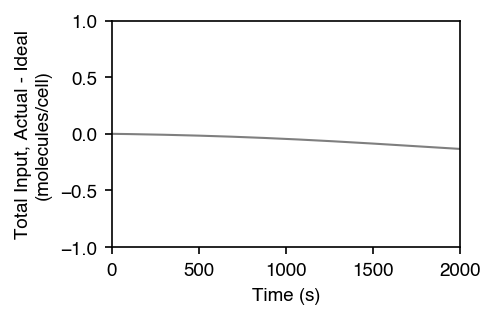

In [519]:
fig, ax = plt.subplots(figsize=(3,2))

input_monomer = 0
species_with_input = np.hstack(([input_monomer],\
                                [m+dimer for dimer,monomers in enumerate(dimers) if \
                                 len(set(monomers).intersection(set([input_monomer])))>0]))

stoichiometry = np.hstack(([1],[np.sum(monomers==input_monomer) for dimer,monomers in enumerate(dimers) if \
                                 len(set(monomers).intersection(set([input_monomer])))>0]))

sum_actual = np.sum(solved_kinetics[species_with_input,:]*np.expand_dims(stoichiometry,axis=1),axis=0)
sum_ideal = np.sum(eq_concs[:,species_with_input]*stoichiometry,axis=1)
_ = ax.plot(timepoints,sum_actual-sum_ideal,\
                marker='',lw=1,linestyle='-',color='k',alpha=0.5)

_ = ax.set_xlabel('Time (s)')
_ = ax.set_ylabel(f'Total Input, Actual - Ideal\n(molecules/cell)')

_ = ax.set_ylim([-1,1])
_ = ax.set_xlim([0,2000])